# Data manipulation with numpy: tips and tricks, part 1

Some inobvious examples of what you can do with numpy are collected here.

Examples are mostly coming from area of machine learning, but will be useful if you're doing number crunching in python.

In [1]:
%pylab inline
import numpy

Populating the interactive namespace from numpy and matplotlib


## 1. numpy.argsort

### Sorting values of one array according to the other

Say, we want to order the people according to their age and their heights.

In [2]:
ages = numpy.random.randint(low=30, high=60, size=10)
heights =  numpy.random.randint(low=150, high=210, size=10)
print ages
print heights

[48 57 40 53 50 59 54 53 32 36]
[166 171 202 168 156 181 195 160 153 178]


In [3]:
sorter = numpy.argsort(ages)
print ages[sorter]
print heights[sorter]

[32 36 40 48 50 53 53 54 57 59]
[153 178 202 166 156 168 160 195 171 181]


once you computed permutation, you can apply it many times - this is fast. 

Frequently to solve this problem people use sorted(zip(ages, heights)), which is much slower (10-20 times slower on large arrays).

### Computing inverse of permutation

permutations in numpy are simply arrays:

In [4]:
permutation = numpy.random.permutation(10)
original = numpy.array(list('abcdefghij'))

print permutation
print original
print original[permutation]

[3 6 2 5 8 0 9 1 7 4]
['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j']
['d' 'g' 'c' 'f' 'i' 'a' 'j' 'b' 'h' 'e']


__Inverse permutation__ is computed using numpy.argsort (again!)

In [5]:
inverse_permutation = numpy.argsort(permutation)

print original[permutation][inverse_permutation]

['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j']


__This is true because of two facts__:

1. indexing operation is associative (dramatically simple and interesting fact):
   ```
   a[b][c] = a[b[c]]
   ```
   provided that `a`, `b`, `c` are 1-dimensional arrays
   
2. `permutation[inverse_permutation] is identical permutation:

In [6]:
permutation[inverse_permutation]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### Computing order of elements in array

frequently it is important to compute order of each value in array. 

In other words, for each element in array we want to find the number of elements smaller than given.

In [7]:
data = numpy.random.random(10)

print data
print numpy.argsort(numpy.argsort(data))

[ 0.18876798  0.33988201  0.57112439  0.17273985  0.85323547  0.45800298
  0.22264742  0.61841973  0.95750711  0.464747  ]
[1 3 6 0 8 4 2 7 9 5]


__NB:__ there is scipy function which does the same, but it's more general and faster, so prefer using it:

In [8]:
from scipy.stats import rankdata
rankdata(data) - 1

array([ 1.,  3.,  6.,  0.,  8.,  4.,  2.,  7.,  9.,  5.])

### IronTransform (flattener of distribution)

Sometimes you need to write monotonic tranformation, which turns one distribution into uniform.

This method is useful to compare distributions or to work with distributions with heavy tails or strange shape.

In [9]:
class IronTransform:
    def fit(self, data, weights):
        weights = weights / numpy.sum(weights)
        sorter = numpy.argsort(data)
        self.x = data[sorter]
        self.y = numpy.cumsum(weights[sorter])
        return self
        
    def transform(self, data):
        return numpy.interp(data, self.x, self.y)

Let's apply __Iron__ transformation to data

In [10]:
sig_pred = numpy.random.normal(size=10000) + 1
bck_pred = numpy.random.normal(size=10000) - 1

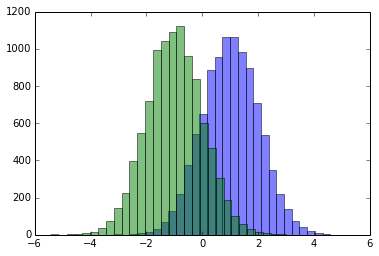

In [11]:
hist(sig_pred, bins=30, alpha=0.5)
hist(bck_pred, bins=30, alpha=0.5)
pass

Now we can see that __IronTransform__ actually was able to turn signal distribution to uniform:

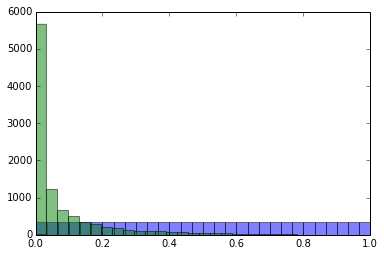

In [12]:
iron = IronTransform().fit(sig_pred, weights=numpy.ones(len(sig_pred)))

hist(iron.transform(sig_pred), bins=30, alpha=0.5)
hist(iron.transform(bck_pred), bins=30, alpha=0.5)
pass

Also worth mentioning: to fight very small / large numbers, use `numpy.clip`. Simple and very handy:

In [13]:
numpy.clip([-100, -10, 0, 10, 100], a_min=-15, a_max=15)

array([-15, -10,   0,  10,  15])

In [14]:
x =numpy.arange(-5, 5)
print x
print x.clip(0)

[-5 -4 -3 -2 -1  0  1  2  3  4]
[0 0 0 0 0 0 1 2 3 4]


# 2. Broadcasting, numpy.newaxis

[Broadcasting](http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) is very useful trick, which simplifies many operations.

### Weighted covariation matrix
numpy has `cov` function, but it doesn't support weights of samples. Let's write our own covariation matrix.

Let $X_{ij}$ be the original data. $i$ is indexing samples, $j$ is indexing features.
$COV_{jk} = \sum_i X_{ij} w_i X_{ik}$

In [15]:
data = numpy.random.normal(size=[100, 5])
weights = numpy.random.random(100)

In [16]:
def covariation(data, weights):
    weights = weights / weights.sum()
    return data.T.dot(weights[:, numpy.newaxis] * data)

In [17]:
numpy.cov(data.T)

array([[ 0.90685165,  0.00356514, -0.12894716,  0.03937398,  0.1663906 ],
       [ 0.00356514,  0.8246978 , -0.01201887,  0.10577941,  0.18562202],
       [-0.12894716, -0.01201887,  1.32759486,  0.03333471, -0.08284814],
       [ 0.03937398,  0.10577941,  0.03333471,  1.02440454, -0.06659497],
       [ 0.1663906 ,  0.18562202, -0.08284814, -0.06659497,  0.94100981]])

In [18]:
covariation(data, numpy.ones(len(data)))

array([[  9.09816762e-01,  -3.12337423e-04,  -1.26838506e-01,
          6.67539288e-02,   1.40262953e-01],
       [ -3.12337423e-04,   8.17677359e-01,  -1.21602154e-02,
          9.58546593e-02,   1.91576029e-01],
       [ -1.26838506e-01,  -1.21602154e-02,   1.31437468e+00,
          3.48920447e-02,  -8.36850199e-02],
       [  6.67539288e-02,   9.58546593e-02,   3.48920447e-02,
          1.07826235e+00,  -1.22391496e-01],
       [  1.40262953e-01,   1.91576029e-01,  -8.36850199e-02,
         -1.22391496e-01,   9.81333236e-01]])

In [19]:
covariation(data, weights)

array([[  9.82174593e-01,  -2.38659658e-02,  -1.52640434e-01,
          1.59653486e-01,   1.70825366e-01],
       [ -2.38659658e-02,   7.90875598e-01,   3.09576460e-02,
          1.30379765e-02,   1.78000700e-01],
       [ -1.52640434e-01,   3.09576460e-02,   1.37891092e+00,
         -5.91108276e-04,   2.21618059e-02],
       [  1.59653486e-01,   1.30379765e-02,  -5.91108276e-04,
          1.05140876e+00,  -1.36853522e-01],
       [  1.70825366e-01,   1.78000700e-01,   2.21618059e-02,
         -1.36853522e-01,   1.11695337e+00]])

alternative way to do this is via `numpy.einsum`:

In [20]:
numpy.einsum('ij, ik, i -> jk', data, data, weights / weights.sum())

array([[  9.82174593e-01,  -2.38659658e-02,  -1.52640434e-01,
          1.59653486e-01,   1.70825366e-01],
       [ -2.38659658e-02,   7.90875598e-01,   3.09576460e-02,
          1.30379765e-02,   1.78000700e-01],
       [ -1.52640434e-01,   3.09576460e-02,   1.37891092e+00,
         -5.91108276e-04,   2.21618059e-02],
       [  1.59653486e-01,   1.30379765e-02,  -5.91108276e-04,
          1.05140876e+00,  -1.36853522e-01],
       [  1.70825366e-01,   1.78000700e-01,   2.21618059e-02,
         -1.36853522e-01,   1.11695337e+00]])

### Pearson correlation

One more example of broadcasting: computation of Pearson coefficient.


In [21]:
numpy.corrcoef(data.T)

array([[ 1.        ,  0.0041225 , -0.11751976,  0.04085126,  0.18012069],
       [ 0.0041225 ,  1.        , -0.01148639,  0.11508481,  0.21070992],
       [-0.11751976, -0.01148639,  1.        ,  0.02858434, -0.07412299],
       [ 0.04085126,  0.11508481,  0.02858434,  1.        , -0.06782794],
       [ 0.18012069,  0.21070992, -0.07412299, -0.06782794,  1.        ]])

In [22]:
def my_corrcoef(data, weights):
    data = data - numpy.average(data, axis=0, weights=weights)
    shifted_cov = covariation(data, weights)
    cov_diag = numpy.diag(shifted_cov)
    return shifted_cov / numpy.sqrt(cov_diag[:, numpy.newaxis] * cov_diag[numpy.newaxis, :])

my_corrcoef(data, numpy.ones(len(data)))

array([[ 1.        ,  0.0041225 , -0.11751976,  0.04085126,  0.18012069],
       [ 0.0041225 ,  1.        , -0.01148639,  0.11508481,  0.21070992],
       [-0.11751976, -0.01148639,  1.        ,  0.02858434, -0.07412299],
       [ 0.04085126,  0.11508481,  0.02858434,  1.        , -0.06782794],
       [ 0.18012069,  0.21070992, -0.07412299, -0.06782794,  1.        ]])

### Pairwise distances between vectors

we're given a set of vectors (say, 1000 vectors). The problem is to compute their pairwise distances.

In [23]:
X = numpy.random.normal(size=[1000, 100])
distances = ((X[:, numpy.newaxis, :] - X[numpy.newaxis, :, :]) ** 2).sum(axis=2) ** 0.5

also, since algebra is you friend, you can do it times faster: 
$$||x_i - x_j||^2 = ||x_i||^2 + ||x_j||^2 - 2 (x_i, x_j) $$
so dot products is the only thing you need.

In [24]:
products = X.dot(X.T)
distances2 = products.diagonal()[:, numpy.newaxis] + products.diagonal()[numpy.newaxis, :]  - 2 * products
distances2 **= 0.5

... but keep in mind there is __sklearn.metrics.pairwise__ which does it for you and has different options

In [25]:
from sklearn.metrics.pairwise import pairwise_distances
distances_sklearn = pairwise_distances(X)

numpy.allclose(distances, distances_sklearn), numpy.allclose(distances2, distances_sklearn)

(True, True)

# 3. numpy.unique, numpy.searchsorted

### Converting categories to small integers

Despite categories are easier to read, operating with them is much faster after you represent them as small numbers <br /> (for instance, in range [0, n_categories - 1])

First generate some categories:

In [26]:
from itertools import combinations
possible_categories = map(lambda x: x[0] + x[1], list(combinations('abcdefghijklmn', 2)))
categories = numpy.random.choice(possible_categories, size=10000)
print categories

['di' 'jk' 'ik' ..., 'dl' 'af' 'af']


Now we use __numpy.unique__ to convert them to numbers (pay attention to `return_inverse=True`)

In [27]:
unique_categories, new_categories = numpy.unique(categories, return_inverse=True)

In [28]:
print unique_categories
print new_categories

['ab' 'ac' 'ad' 'ae' 'af' 'ag' 'ah' 'ai' 'aj' 'ak' 'al' 'am' 'an' 'bc' 'bd'
 'be' 'bf' 'bg' 'bh' 'bi' 'bj' 'bk' 'bl' 'bm' 'bn' 'cd' 'ce' 'cf' 'cg' 'ch'
 'ci' 'cj' 'ck' 'cl' 'cm' 'cn' 'de' 'df' 'dg' 'dh' 'di' 'dj' 'dk' 'dl' 'dm'
 'dn' 'ef' 'eg' 'eh' 'ei' 'ej' 'ek' 'el' 'em' 'en' 'fg' 'fh' 'fi' 'fj' 'fk'
 'fl' 'fm' 'fn' 'gh' 'gi' 'gj' 'gk' 'gl' 'gm' 'gn' 'hi' 'hj' 'hk' 'hl' 'hm'
 'hn' 'ij' 'ik' 'il' 'im' 'in' 'jk' 'jl' 'jm' 'jn' 'kl' 'km' 'kn' 'lm' 'ln'
 'mn']
[40 81 77 ..., 43  4  4]


Also we can reconstruct old categories if needed:

In [29]:
print categories
print unique_categories[new_categories]

['di' 'jk' 'ik' ..., 'dl' 'af' 'af']
['di' 'jk' 'ik' ..., 'dl' 'af' 'af']


### Mapping new categories

When we need to map new categories using the same lookup table, we can use `numpy.searchsorted`

In [30]:
categories2 = numpy.random.choice(possible_categories, size=10000)
new_categories2 = numpy.searchsorted(unique_categories, categories2)
print categories2
print unique_categories[new_categories2]

['ak' 'be' 'jn' ..., 'fg' 'dk' 'ei']
['ak' 'be' 'jn' ..., 'fg' 'dk' 'ei']


### Checking values present in the lookup

Usually, we use `set` to have many checks that each element exists in array. But __numpy.unique__ is better option - it works dozens times faster.

In [31]:
numpy.in1d(['ab', 'ac', 'something new'], unique_categories)

array([ True,  True, False], dtype=bool)

### Handling missing categories

When some new category appears in test data, this is always a trouble. Possible solutions:

* map randomly to one of present categories (this, i.e. is done by hashing trick)
* make a special category 'unknown' where all new values will be mapped. Then special value may be chosen for it.
  This approach is more general, but requires more efforts.

Below you can find the transformer for second approach:

In [32]:
class CategoryMapper:
    def fit(self, categories):
        self.lookup = numpy.unique(categories)
        return self
        
    def transform(self, categories):
        """Converts categories to numbers, 0 is reserved for new values (not present in fitted data)"""
        return (numpy.searchsorted(self.lookup, categories) + 1) * numpy.in1d(categories, self.lookup)    

In [33]:
CategoryMapper().fit(categories).transform([unique_categories[0], 'abc'])

array([1, 0])

# 4. numpy.percentile, numpy.bincount


### Splitting data into bins

Splitting data into bins is frequently necessary. Simplest way done e.g. by `numpy.histogram` is splitting region with even bins of same size.

This usually works poorly with distributions with long tails (or strange shape) and requires additional transformation to avoid empty or too large bins.

However, for most cases creating the bins with equal number of events gives more convenient and stable results.
Selecting the edges of bins can be done with `numpy.percentile`.

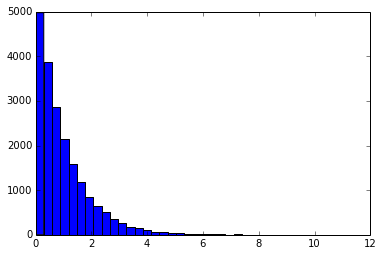

In [34]:
x = numpy.random.exponential(size=20000)
_ = hist(x, bins=40)

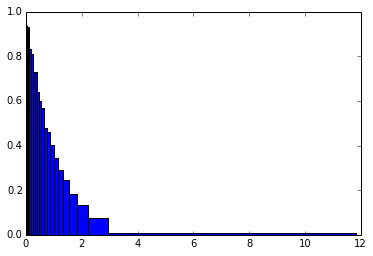

In [35]:
edges = numpy.percentile(x, numpy.linspace(0, 100, 20))
_ = hist(x, bins=edges, normed=True)

the number of events within each bin is equal now.

### Defining the index of bin

Use `numpy.searchsorted` to compute the index of bin for each value in `x`. (`numpy.digitize` is the other option, it does the same).

`numpy.searchsorted` assumes that first array is sorted and uses binary search, so it is effective even for large amount of bins.

In [36]:
numpy.searchsorted(edges, x)

array([16, 10, 10, ..., 11,  8,  6])

###  Counter

Need to know number of occurences for each category? Use `numpy.bincount` to compute the statistics:

In [37]:
new_categories

array([40, 81, 77, ..., 43,  4,  4])

This will compute how many times each category present in the data:


In [38]:
numpy.bincount(new_categories)

array([106, 112, 122, 112, 130, 114, 105, 105, 139, 120,  94,  96, 112,
       112,  97, 110, 115, 122, 101,  98, 117,  98,  96, 125,  94, 120,
       103, 101, 103, 108,  93, 103, 113, 131, 123, 107,  95, 121, 117,
        88, 107, 106, 108, 113, 123, 120, 116, 125, 126,  92,  96, 108,
       116, 102, 102, 101, 110, 111, 124, 112, 128,  99,  88, 113, 119,
       124, 103, 111, 123, 126, 102,  96, 116, 117,  98, 118, 115, 110,
       101, 106,  96, 103, 123, 120, 113, 111, 107, 102, 107, 103, 106])

the same done with `collections.Counter`

In [39]:
from collections import Counter
numpy.array(sorted(Counter(new_categories).items()))[:, 1]

array([106, 112, 122, 112, 130, 114, 105, 105, 139, 120,  94,  96, 112,
       112,  97, 110, 115, 122, 101,  98, 117,  98,  96, 125,  94, 120,
       103, 101, 103, 108,  93, 103, 113, 131, 123, 107,  95, 121, 117,
        88, 107, 106, 108, 113, 123, 120, 116, 125, 126,  92,  96, 108,
       116, 102, 102, 101, 110, 111, 124, 112, 128,  99,  88, 113, 119,
       124, 103, 111, 123, 126, 102,  96, 116, 117,  98, 118, 115, 110,
       101, 106,  96, 103, 123, 120, 113, 111, 107, 102, 107, 103, 106])

### Replace category with number of occurences

There are several tricks important to process the categorical features. 
Most known one is one-hot encoding, but let's speak about others.

One of tricks is to replace in each event category (which cannot be processed by most algorithms) with a number of times it presents in data. 

This can be written in __numpy__ one-liner:

In [40]:
numpy.bincount(new_categories)[new_categories]

array([107, 103, 110, ..., 113, 130, 130])

### Averaging predictions over category

Another important trick: replace category with average prediction for events from this category.

This is more tricky, since we need to add weights to `numpy.bincount`:

In [41]:
predictions = numpy.random.normal(size=len(new_categories))

In [42]:
means_over_category = numpy.bincount(new_categories, weights=predictions) / numpy.bincount(new_categories)
means_over_category[new_categories]

array([-0.12953239, -0.17997224, -0.16147434, ..., -0.11826536,
        0.22681523,  0.22681523])

### Variation of predictions over category

The same trick can be applied to measure deviation after invloving some math:
$$ \mathbb{V}x = \mathbb{E}x^2 - (\mathbb{E}x)^2 $$

In [43]:
means_of_squares_over_category = numpy.bincount(new_categories, weights=predictions**2) / numpy.bincount(new_categories)
var_over_category = means_of_squares_over_category - means_over_category ** 2
var_over_category[new_categories]

array([ 1.12103301,  0.7602834 ,  1.06631312, ...,  0.9993211 ,
        0.90302807,  0.90302807])

You can also assign weights to events and compute weighted mean / weighted variation using the same functions.

### Even faster inverse permutation

As was said, numpy.argsort returns inverse permutation, but it takes $O(n \log(n))$ time, while computing inverse permutation should take $O(n)$.

This optimal way (`inplace sort`) can be written in numpy.

In [44]:
print numpy.argsort(permutation)
print numpy.bincount(permutation, numpy.arange(len(permutation))).astype(int)

[5 7 2 0 9 3 1 8 4 6]
[5 7 2 0 9 3 1 8 4 6]


## 5. Numpy.ufunc.at

To proceed futher, we need to know that there is class of binary (and unary) functions: `numpy.ufuncs`

Examples: `numpy.add`, `numpy.subtract`, `numpy.multiply`, `numpy.maximum`, `numpy.minimum`

In the following example we preapre a new column with max predictions over category using `ufunc.at`

In [45]:
max_over_category = numpy.zeros(new_categories.max() + 1) - numpy.infty
numpy.maximum.at(max_over_category, new_categories, predictions)

print max_over_category[new_categories]

[ 3.61783384  2.46205985  2.44882542 ...,  2.89520716  2.6390576   2.6390576 ]


Important note: `numpy.add.at` and `numpy.bincount` are very similar, but latter is dozens of times faster. Always prefer it to `numpy.add.at`

In [46]:
%timeit numpy.add.at(max_over_category, new_categories, predictions)
%timeit numpy.bincount(new_categories, weights=predictions)

100 loops, best of 3: 1.9 ms per loop
10000 loops, best of 3: 35.4 µs per loop


### Multidimensional statistics: numpy.add.at and smart indexing

When need to compute number of times each combination met, there are two ways:
1. convert couple of variables to new variable, e.g. by feature1 * (numpy.max(feature2) + 1) + feature2
2. create multidimensional table

I prefer first, code below is demonstration of second approach and it's benefits.

In [47]:
first_category = numpy.random.randint(0, 100, len(new_categories))
second_category = numpy.random.randint(0, 100, len(new_categories))

In [48]:
counters = numpy.zeros([first_category.max() + 1, second_category.max() + 1])
numpy.add.at(counters, [first_category, second_category], 1)

Now some useful things we can do with colected statistic. First thing is create feature, for which we use fancy indexing:

In [49]:
counters[first_category, second_category]

array([ 3.,  2.,  3., ...,  2.,  1.,  1.])

We can also infer different statistics like:

In [50]:
# occurences of second category
counters.sum(axis=0)[second_category]

array([ 105.,   84.,  116., ...,   98.,   88.,  111.])

In [51]:
# maximal occurences of second category with same value of first category
counters.max(axis=0)[second_category]

array([ 4.,  4.,  4., ...,  6.,  4.,  4.])

In [52]:
# number of occurences of second category with fixed first category:
counters[42, second_category]

array([ 2.,  0.,  3., ...,  0.,  1.,  1.])

* you are not limited to numpy.add, remember there are other ufuncs.
* Few space to keep whole matrix? Use `scipy.sparse` if there are too many zero elements. 
  Alternatively, you can use matrix decompositions to keep approximation of matrix and compute result on-the-fly.

### Computing ROC curve

As an important exercise, let's implement the computation of ROC curve. 

We will write the same as `sklearn.metrics.roc_curve`, 
but this time no C++, only `numpy`.

ROC curve takes three arrays: labels (binary, 0 or 1), predictions (real-valued) and weights.

In [53]:
def roc_curve(labels, predictions, sample_weight):
    sig_weights = sample_weight * (labels == 1)
    bck_weights = sample_weight * (labels == 0)
    thresholds, predictions = numpy.unique(predictions, return_inverse=True)
    tpr = numpy.bincount(predictions, weights=sig_weights)[::-1].cumsum()
    fpr = numpy.bincount(predictions, weights=bck_weights)[::-1].cumsum()
    tpr /= tpr[-1]
    fpr /= fpr[-1]
    return fpr, tpr, thresholds[::-1]

In [54]:
numpy.random.seed(1)
size = 1000
labels = (numpy.random.random(size) > 0.5) * 1
predictions = numpy.random.normal(size=size)
weights = numpy.random.exponential(size=size)

In [55]:
fpr1, tpr1, thr1 = roc_curve(labels, predictions, weights)

In [56]:
# sometims sklearn adds one more element to all arrays.
# I have no idea why this is needed and when, but in this case all answers turn to False
from sklearn.metrics import roc_curve as sklearn_roc_curve
fpr2, tpr2, thr2 = sklearn_roc_curve(labels, predictions, sample_weight=weights)
numpy.allclose(fpr1, fpr2), numpy.allclose(tpr1, tpr2), numpy.allclose(thr1, thr2)

(True, True, True)

### Weighted Kolmogorov-Smirnov distance

ROC curve is an important object by itself and freqently used in ML to compare distribution, 
but the magic is that it contains all order-based information about original distributions.

Next we compute KS distance based on ROC curve:

$$ KS = \max_x \left| F_1(x) - F_2(x) \right| $$

(Order-based information == information, which is preserved under monotonic transformations)

In [57]:
def ks_2samp(distribution1, distribution2, weights1, weights2):
    labels = numpy.array([0] * len(distribution1) + [1] * len(distribution2))
    predictions = numpy.concatenate([distribution1, distribution2])
    weights = numpy.concatenate([weights1, weights2])

    fpr, tpr, _ = roc_curve(labels, predictions, sample_weight=weights)
    return numpy.max(numpy.abs(fpr - tpr))

In [58]:
data1 = numpy.random.normal(loc=0, size=size)
data2 = numpy.random.normal(loc=1, size=size)
weights1 = numpy.random.exponential(size=size) 
weights2 = numpy.random.exponential(size=size) 

__Compare results__ with standard function:

In [59]:
from scipy.stats import ks_2samp as ks_2samp_scipy
print ks_2samp(data1, data2, weights1=numpy.ones(size), weights2=numpy.ones(size))
print ks_2samp_scipy(data1, data2)[0]

0.416
0.416


Important moment that written function supports weights, while scipy version doesn't.

## Conclusion

Many things can be written in numpy in efficient way, moreover resulting code will be short and (surpise!) more readable. 

But this skill requires much practice.

## See also

* Second part of post: [numpy tips and tricks 2](/2015/09/30/NumpyTipsAndTricks2.html)
* [Numpy log-likelihood benchmark](/2015/09/08/SpeedBenchmarks.html)
